# BIZ 프로젝트 : 부실기업 예측

## Step2 : 데이터 전처리

부실기업은 과거 3년간 연속해 이자보상 배율이 1.0미만인 기업을 의미하며  
이를 이용하여 타겟변수인 부실기업여부 변수를 생성

### 필요라이브러리 불러오기

In [126]:
import pandas as pd
import numpy as np

### 데이터 불러오기

In [127]:
RANDOM_STATE = 110

data = pd.read_csv("../../project/data/clean_financial_data.csv", encoding='utf-8-sig', low_memory=False)
print(data.shape)

(38639, 543)


In [128]:
data.columns

Index(['업체코드', '종목코드', '종목명', '2020/총자산증가율', '2021/총자산증가율', '2022/총자산증가율',
       '2023/총자산증가율', '2024/총자산증가율', '2020/유형자산증가율', '2021/유형자산증가율',
       ...
       '2020/조세공과(구성비)', '2021/조세공과(구성비)', '2022/조세공과(구성비)', '2023/조세공과(구성비)',
       '2024/조세공과(구성비)', '2020/감가상각비(구성비)', '2021/감가상각비(구성비)',
       '2022/감가상각비(구성비)', '2023/감가상각비(구성비)', '2024/감가상각비(구성비)'],
      dtype='object', length=543)

In [129]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 각 열에 대해 결측치 개수와 비율 계산
missing_data = data[columns_with_ratio].isnull().sum()
missing_ratio = (missing_data / len(data)) * 100  # 결측치 비율 계산 (퍼센트)

# 결측치가 있는 열만 출력
missing_summary = pd.DataFrame({
    '결측치 개수': missing_data,
    '결측치 비율 (%)': missing_ratio
}).loc[missing_data > 0]

# 결과 출력
print(missing_summary)


                 결측치 개수  결측치 비율 (%)
2020/영업이익이자보상비율    8768   22.692099
2021/영업이익이자보상비율    6378   16.506638
2022/영업이익이자보상비율    4472   11.573798
2023/영업이익이자보상비율    4810   12.448562
2024/영업이익이자보상비율   37943   98.198711


- 2024년 데이터는 target변수인 '영업이익이자보상비율'의 대부분이 결측치이므로 제거

In [130]:
# '2024'가 열 이름에 포함된 열들을 제거
data = data.drop(columns=[col for col in data.columns if '2024' in col], errors='ignore')
print(data.shape)

(38639, 435)


In [131]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 결측치가 있는 행 제거
data = data.dropna(subset=columns_with_ratio)

# 결과 확인
print(data.shape)

(27604, 435)


In [132]:
# 각 열의 결측값을 중앙값으로 대체
data = data.fillna(data.median(numeric_only=True))

In [133]:
data.dtypes

업체코드                object
종목코드                object
종목명                 object
2020/총자산증가율        float64
2021/총자산증가율        float64
                    ...   
2023/조세공과(구성비)     float64
2020/감가상각비(구성비)    float64
2021/감가상각비(구성비)    float64
2022/감가상각비(구성비)    float64
2023/감가상각비(구성비)    float64
Length: 435, dtype: object

In [134]:
# 숫자형 변수 개수 확인
numeric_columns = data.select_dtypes(include=['number']).columns
numeric_count = len(numeric_columns)

print(f"숫자형 변수 개수: {numeric_count}개")

숫자형 변수 개수: 432개


In [135]:
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False


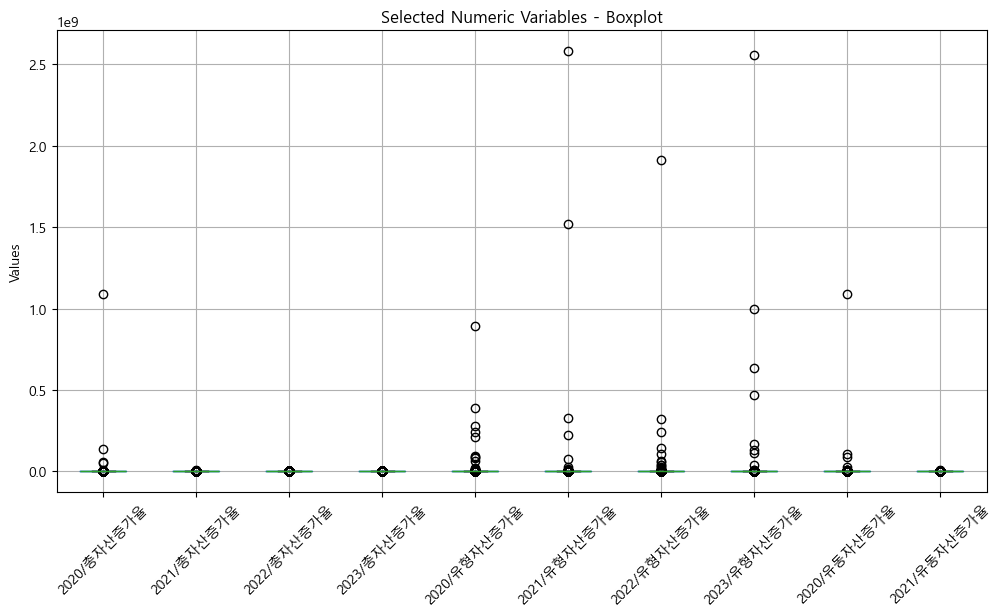

In [136]:
import matplotlib.pyplot as plt

# 숫자형 변수 선택
numeric_columns = data.select_dtypes(include=['number']).columns

# 숫자형 변수 중 일부 선택 (예: 앞에서 10개)
selected_columns = numeric_columns[:10]

# 선택된 변수에 대한 박스플롯 그리기
plt.figure(figsize=(12, 6))
data[selected_columns].boxplot(rot=45)
plt.title("Selected Numeric Variables - Boxplot")
plt.ylabel("Values")
plt.show()


In [137]:
from scipy.stats.mstats import winsorize

# 숫자형 데이터에만 윈저라이징 적용
numeric_columns = data.select_dtypes(include=['number']).columns

for col in numeric_columns:
    # 0.01 이하와 0.99 이상을 해당 값으로 제한
    lower_limit = data[col].quantile(0.01)
    upper_limit = data[col].quantile(0.99)
    data[col] = data[col].clip(lower=lower_limit, upper=upper_limit)


data.head(5)


,업체코드,종목코드,종목명,2020/총자산증가율,2021/총자산증가율,2022/총자산증가율,2023/총자산증가율,2020/유형자산증가율,2021/유형자산증가율,2022/유형자산증가율,...,2022/임차료(구성비),2023/임차료(구성비),2020/조세공과(구성비),2021/조세공과(구성비),2022/조세공과(구성비),2023/조세공과(구성비),2020/감가상각비(구성비),2021/감가상각비(구성비),2022/감가상각비(구성비),2023/감가상각비(구성비)
0,N350605,A000020,동화약품,7.57,2.70,3.27,10.23,19.67,10.41,7.64,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
1,N320498,A000040,KR모터스,-36.76,1.45,-0.52,-4.89,-0.29,5.78,4.85,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
2,N320684,A000050,경방,-6.47,0.15,-6.09,-1.40,-36.42,-23.56,665.18,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
3,N320730,A000070,삼양홀딩스,6.31,22.28,-0.76,17.63,-45.53,943.89,0.68,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
4,N310581,A000080,하이트진로,-0.99,10.65,-9.43,-0.03,-6.75,-2.60,-1.51,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22


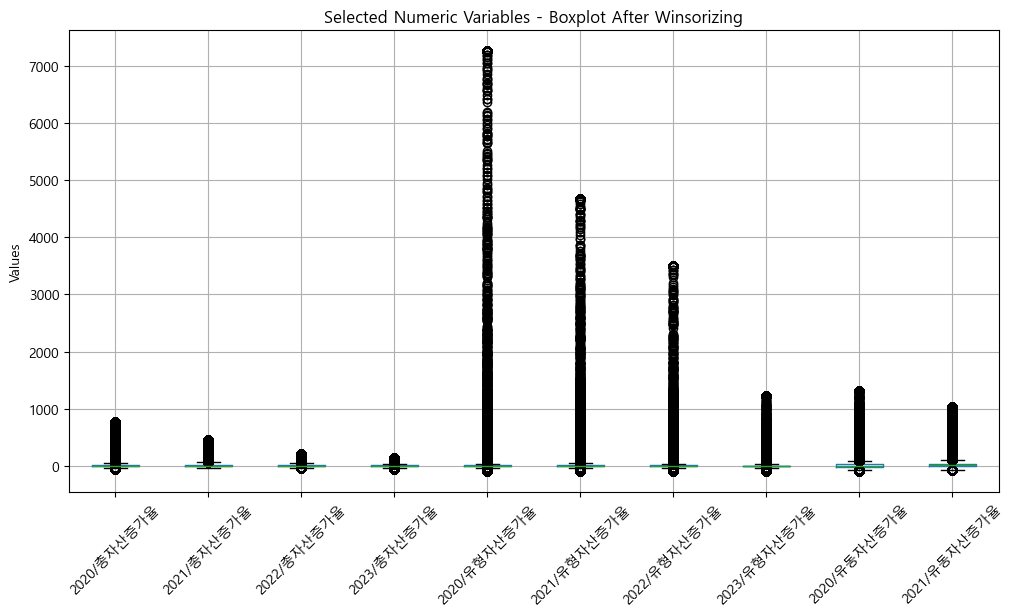

In [138]:
import matplotlib.pyplot as plt

selected_columns = numeric_columns[:10]  # 이전에 선택한 numeric_columns 그대로 사용

# 윈저라이징 후 선택된 변수에 대한 박스플롯 그리기
plt.figure(figsize=(12, 6))
data[selected_columns].boxplot(rot=45)
plt.title("Selected Numeric Variables - Boxplot After Winsorizing")
plt.ylabel("Values")
plt.show()


In [139]:
# import numpy as np

# # 로그 변환
# data_log_scaled = data[selected_columns].apply(lambda x: np.log1p(x))

# # 로그 변환 후 박스플롯
# plt.figure(figsize=(12, 6))
# data_log_scaled.boxplot(rot=45)
# plt.title("Selected Numeric Variables - Boxplot After Log Transformation")
# plt.ylabel("Log-Scaled Values")
# plt.show()


In [140]:
data['2021/영업이익이자보상비율'] < 1

0        False
1         True
2        False
3        False
4        False
         ...  
38634     True
38635    False
38636    False
38637    False
38638    False
Name: 2021/영업이익이자보상비율, Length: 27604, dtype: bool

- 0이면 부실기업이 아닌 기업, 1이면 부실기업을 의미

In [141]:
# 2023/부실기업 변수 생성 및 값 할당
data['2023/부실기업'] = ((data['2021/영업이익이자보상비율'] < 1) & 
                        (data['2022/영업이익이자보상비율'] < 1) & 
                        (data['2023/영업이익이자보상비율'] < 1)).astype(int)

print("\n2023/부실기업 변수 값:")
print(data['2023/부실기업'].value_counts())


2023/부실기업 변수 값:
2023/부실기업
0    22473
1     5131
Name: count, dtype: int64


C:\Users\ldb76\AppData\Local\Temp\ipykernel_14892\799345054.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['2023/부실기업'] = ((data['2021/영업이익이자보상비율'] < 1) &


In [142]:
data.isnull().sum()

업체코드                   0
종목코드               24402
종목명                    1
2020/총자산증가율            0
2021/총자산증가율            0
                   ...  
2020/감가상각비(구성비)        0
2021/감가상각비(구성비)        0
2022/감가상각비(구성비)        0
2023/감가상각비(구성비)        0
2023/부실기업              0
Length: 436, dtype: int64

In [143]:
# '종목명' 열에서 null 값이 있는 행 제거
data = data[data['종목명'].notnull()]

이때 종목코드 x -> 해당 기업이 상장되지 않은 경우

In [144]:
# '종목코드' 열의 값이 있으면 1, 없으면 0을 부여하는 새로운 열 생성
data['상장여부'] = data['종목코드'].notnull().astype(int)

# '종목코드' 열 제거
data = data.drop(columns=['종목코드'])

C:\Users\ldb76\AppData\Local\Temp\ipykernel_14892\292392295.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['상장여부'] = data['종목코드'].notnull().astype(int)


In [145]:
data.isnull().sum()

업체코드               0
종목명                0
2020/총자산증가율        0
2021/총자산증가율        0
2022/총자산증가율        0
                  ..
2021/감가상각비(구성비)    0
2022/감가상각비(구성비)    0
2023/감가상각비(구성비)    0
2023/부실기업          0
상장여부               0
Length: 436, dtype: int64

In [146]:
data.dtypes

업체코드                object
종목명                 object
2020/총자산증가율        float64
2021/총자산증가율        float64
2022/총자산증가율        float64
                    ...   
2021/감가상각비(구성비)    float64
2022/감가상각비(구성비)    float64
2023/감가상각비(구성비)    float64
2023/부실기업            int32
상장여부                 int32
Length: 436, dtype: object

20~22년도 데이터 선택

In [147]:
import pandas as pd

# 21~23년도 데이터만을 사용하기 위해 해당 연도가 포함된 열 필터링
years = ['2020', '2021', '2022']
cols_to_keep = ['업체코드', '종목명','상장여부','2023/부실기업'] + [col for col in data.columns if any(year in col for year in years)]

# 필터링된 열들로 새로운 데이터프레임 생성
data = data[cols_to_keep]

# 결과 확인
print("필터링된 데이터프레임의 열들:")
print(data.columns)

필터링된 데이터프레임의 열들:
Index(['업체코드', '종목명', '상장여부', '2023/부실기업', '2020/총자산증가율', '2021/총자산증가율',
       '2022/총자산증가율', '2020/유형자산증가율', '2021/유형자산증가율', '2022/유형자산증가율',
       ...
       '2022/금융비용(구성비)', '2020/임차료(구성비)', '2021/임차료(구성비)', '2022/임차료(구성비)',
       '2020/조세공과(구성비)', '2021/조세공과(구성비)', '2022/조세공과(구성비)', '2020/감가상각비(구성비)',
       '2021/감가상각비(구성비)', '2022/감가상각비(구성비)'],
      dtype='object', length=328)


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27603 entries, 0 to 38638
Columns: 328 entries, 업체코드 to 2022/감가상각비(구성비)
dtypes: float64(324), int32(2), object(2)
memory usage: 69.1+ MB


### t-test

In [149]:
from scipy.stats import ttest_ind

# 타겟 변수 설정
group_0 = data[data['2023/부실기업'] == 0]  # 부실기업이 아닌 그룹
group_1 = data[data['2023/부실기업'] == 1]  # 부실기업 그룹

# 숫자형 변수 선택 및 제외할 열들 제거
numeric_columns = data.select_dtypes(include=['number']).columns.drop('2023/부실기업')

# t-검정 결과 저장
t_test_results = []

for col in numeric_columns:
    # 각 변수에 대해 t-검정 수행
    t_stat, p_value = ttest_ind(group_0[col].dropna(), group_1[col].dropna(), equal_var=False)  # Welch's t-test
    t_test_results.append({'변수': col, 't-값': t_stat, 'p-값': p_value})

# t-검정 결과를 데이터프레임으로 정리
t_test_df = pd.DataFrame(t_test_results)

# 유의미한 변수 필터링 (p-값 < 0.05)
significant_vars = t_test_df[t_test_df['p-값'] < 0.05]

# 결과 출력
print("t-검정 결과 요약:")
print(t_test_df[t_test_df['p-값'] > 0.05].sort_values(by='p-값', ascending=False).head(10))  # p-값 기준 상위 10개 출력
print("제거되는 변수의 갯수: ", len(t_test_df[t_test_df['p-값'] > 0.05]))
print("\n유의미한 변수들:")
print(significant_vars)

t-검정 결과 요약:
                 변수       t-값       p-값
87   2022/인건비/총비용비율  0.133861  0.893515
4      2020/유형자산증가율 -0.190568  0.848869
13     2020/자기자본증가율  0.238941  0.811159
241    2020/유형자산회전율 -0.248338  0.803880
5      2021/유형자산증가율 -0.281332  0.778463
310   2020/인건비(구성비) -0.292772  0.769707
304    2020/노동소득분배율 -0.292772  0.769707
256    2020/매출채권회전율  0.358525  0.719961
29     2021/종업원수증가율  0.368283  0.712674
28     2020/종업원수증가율  0.613943  0.539274
제거되는 변수의 갯수:  23

유의미한 변수들:
                  변수       t-값           p-값
0               상장여부 -3.923307  8.814390e-05
1        2020/총자산증가율 -5.875854  4.420711e-09
2        2021/총자산증가율 -5.444239  5.405659e-08
3        2022/총자산증가율  6.429458  1.367696e-10
7       2020/유동자산증가율 -8.162246  3.961774e-16
..               ...       ...           ...
319   2020/조세공과(구성비) -3.014725  2.582048e-03
320   2021/조세공과(구성비) -3.432897  6.010097e-04
321   2022/조세공과(구성비) -3.097531  1.959583e-03
323  2021/감가상각비(구성비) -4.141930  3.488085e-05
324  2022/감가상각비(구성비) -4.5

In [ ]:
# # 각 연도별 변수 선택
# vars_2021 = [col for col in numeric_columns if col.startswith('2021/')]
# vars_2022 = [col for col in numeric_columns if col.startswith('2022/')]
# vars_2023 = [col for col in numeric_columns if col.startswith('2023/')]

# # 연도별 변수 출력
# print("2021년도 변수들:")
# print(vars_2021)

# print("\n2022년도 변수들:")
# print(vars_2022)

# print("\n2023년도 변수들:")
# print(vars_2023)

# # 연도별 변수들을 사전으로 정리
# yearly_variables = {
#     '2021': vars_2021,
#     '2022': vars_2022,
#     '2023': vars_2023
# }

# # 데이터프레임으로 정리해서 보기 (선택 사항)
# import pandas as pd
# yearly_variables_df = pd.DataFrame(dict([(year, pd.Series(vars)) for year, vars in yearly_variables.items()]))
# print("\n연도별 변수 요약:")
# print(yearly_variables_df)


2021년도 변수들:
['2021/총자산증가율', '2021/유형자산증가율', '2021/유동자산증가율', '2021/재고자산증가율', '2021/자기자본증가율', '2021/매출액증가율', '2021/영업이익증가율', '2021/법인세비용차감전순이익증가율', '2021/순이익증가율', '2021/종업원수증가율', '2021/총자본영업이익율', '2021/총자본법인세비용차감전순이익율', '2021/총자본순이익율', '2021/기업법인세비용차감전순이익율', '2021/기업순이익율', '2021/경영자본영업이익율', '2021/자기자본법인세비용차감전순이익율', '2021/자기자본순이익율', '2021/자본금법인세비용차감전순이익율', '2021/자본금순이익율', '2021/매출액법인세비용차감전순이익율', '2021/매출액순이익율', '2021/매출액총이익율', '2021/매출액영업이익율', '2021/수지비율', '2021/매출원가율', '2021/감가상각율', '2021/감가상각비/총비용비율', '2021/인건비/총비용비율', '2021/조세/조세차감전순이익비율', '2021/조세공과/총비용비율', '2021/금융비용/총부채', '2021/차입금평균이자율', '2021/금융비용/총비용비율', '2021/금융비용/매출액비율', '2021/영업활동현금흐름이자보상비율', '2021/영업이익이자보상비율', '2021/법인세비용차감전순이익이자보상비율', '2021/법인세차감전순이익이자보상비율', '2021/배당율', '2021/배당성향', '2021/상환계수(세전이익)', '2021/부채상환계수', '2021/대출효율성계수(법인세비용차감전순이익)', '2021/EBIT대매출액(세전이익)', '2021/EBITDA대매출액', '2021/EBITDA대금융비용', '2021/자기자본비율', '2021/유동비율', '2021/당좌비율', '2021/현금비율', '2021/비유동자산비율', '2021/비유동자산장기적합율', '2021/부채비율', '2021/유동부채비율', '202

### 로지스틱 회귀분석 & 후진선택법

- 로지스틱 회귀분석에서 변수 검증 : 특정 독립변수가 유의미하게 종속변수와 연관되어 있는지 확인하고, 불필요한 변수를 제거

In [150]:
import statsmodels.api as sm

# '2023/부실기업'을 종속변수로 설정
y = data['2023/부실기업']

# 독립변수: t-test 후 유의한 변수들
X = data[significant_vars['변수']].select_dtypes(include=['number'])

# 상수항 추가
X = sm.add_constant(X)

In [151]:
def backward_elimination(X, y, significance_level=0.05):
    """
    후진 선택법을 이용한 변수 선택
    Args:
    - X: 독립변수 데이터프레임
    - y: 종속변수 시리즈
    - significance_level: 변수 제거 기준 p-value (기본값: 0.05)

    Returns:
    - 최종 모델
    - 선택된 변수 리스트
    """
    while True:
        model = sm.Logit(y, X).fit(disp=False)  # 로지스틱 회귀 모델 적합
        p_values = model.pvalues
        max_p_value = p_values.max()  # 가장 높은 p-value

        if max_p_value > significance_level:  # 기준보다 높은 변수 제거
            excluded_variable = p_values.idxmax()
            print(f"제거된 변수: {excluded_variable}, p-value: {max_p_value}")
            X = X.drop(columns=[excluded_variable])
        else:
            break

    return model, X.columns

In [152]:
# 후진 제거법 수행
final_model, selected_features = backward_elimination(X, y)

# 최종 결과 출력
print("\n선택된 변수들:")
print(selected_features)

# 최종 모델 요약
print("\n최종 모델 요약:")
print(final_model.summary())

c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/법인세차감전순이익이자보상비율, p-value: 0.9999999999999998


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/노동소득분배율, p-value: 0.9999999999999601


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/법인세비용차감전순이익이자보상비율, p-value: 0.9999999999999462


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/노동소득분배율, p-value: 0.9999999999999433


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/법인세비용차감전순이익증가율, p-value: 0.994088060981732


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/법인세차감전순이익이자보상비율, p-value: 0.999999999999973


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/순C/F대차입금비율, p-value: 0.9913139077172421


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/EBIT대매출액(세전이익), p-value: 0.9850340532099398


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/매출채권/상,제품비율, p-value: 0.9818277364211577


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: const, p-value: 0.9742619984154315


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/매입채무/재고자산비율, p-value: 0.971167863052818
제거된 변수: 2022/법인세비용차감전순이익증가율, p-value: 0.9519625343929667
제거된 변수: 2020/감가상각비/총비용비율, p-value: 0.9502886576803433


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/부가가치율, p-value: 0.949693905057538
제거된 변수: 2020/유동비율, p-value: 0.948399438267147
제거된 변수: 2020/자기자본순이익율, p-value: 0.9461863544130015


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/총자본순이익율, p-value: 0.9426885249347204
제거된 변수: 2020/조세공과/총비용비율, p-value: 0.9394343920481492


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/매출채권/상,제품비율, p-value: 0.9371808524466251
제거된 변수: 2020/자본금회전율, p-value: 0.9215939547744048


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/매출액순이익율, p-value: 0.9127860910747754


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/비유동자산비율, p-value: 0.9105099598888202
제거된 변수: 2022/감가상각비(구성비), p-value: 0.9063768913684459


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/매출채권/상,제품비율, p-value: 0.9013736311627951
제거된 변수: 2020/순C/F대차입금비율, p-value: 0.8955663371791962


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/유보액/납입자본비율, p-value: 0.896978427537282
제거된 변수: 2022/자본집약도(종업원1인당), p-value: 0.8937975695191228


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/매입채무회전율, p-value: 0.892856332468035


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/순이익증가율, p-value: 0.8922336174709948


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/기계투자효율, p-value: 0.8897555102897254
제거된 변수: 2022/상(제)품회전율, p-value: 0.8844401004063542


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/재고자산증가율, p-value: 0.875117605674845


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/경영자본영업이익율, p-value: 0.8686282655201886


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/비유동자산장기적합율, p-value: 0.867384572843398
제거된 변수: 2022/영업활동현금흐름이자보상비율, p-value: 0.849743146379135
제거된 변수: 2020/EBITDA대매출액, p-value: 0.847872364996991
제거된 변수: 2020/유동자산증가율, p-value: 0.8373950665913285


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/감가상각비/총비용비율, p-value: 0.8363254635711328


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/매출액순이익율, p-value: 0.8358054757600426
제거된 변수: 2020/법인세비용차감전순이익이자보상비율, p-value: 0.8317808808850231


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/금융비용/매출액비율, p-value: 0.8180418467678882
제거된 변수: 2020/차입금/매출액비율, p-value: 0.817654872235664


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/노동장비율(종업원1인당), p-value: 0.8190491869283272


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/비유동자산비율, p-value: 0.8150269963161993


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/총C/F대매출액비율, p-value: 0.8026368852721313


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/총자본투자효율, p-value: 0.7989984599703543


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/자기자본비율, p-value: 0.7937236020992173


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/매출액총이익율, p-value: 0.7857293449924695
제거된 변수: 2020/부가가치(종업원1인당), p-value: 0.7807076365929726
제거된 변수: 2020/부채상환계수, p-value: 0.7756366148247845
제거된 변수: 2020/사내유보율, p-value: 0.7710180274474043
제거된 변수: 2020/차입금/자기자본, p-value: 0.7694012602681732
제거된 변수: 2022/매출채권/매입채무비율, p-value: 0.7530721346621123
제거된 변수: 2021/수지비율, p-value: 0.7435362032817452
제거된 변수: 2021/순C/F대차입금비율, p-value: 0.7396743409570181
제거된 변수: 2020/매출액순이익율, p-value: 0.7365940271274357
제거된 변수: 2020/매출액법인세비용차감전순이익율, p-value: 0.8713364327622785
제거된 변수: 2021/순운전자본회전율, p-value: 0.7337777039902202
제거된 변수: 2022/총C/F대매출액비율, p-value: 0.725715939976884
제거된 변수: 2020/유동부채비율, p-value: 0.7025911589716357
제거된 변수: 2021/EBIT대매출액(세전이익), p-value: 0.7036239423294472
제거된 변수: 2020/적립금비율, p-value: 0.6990345819017127
제거된 변수: 2022/노동장비율(종업원1인당), p-value: 0.6947601431816387
제거된 변수: 2020/비유동자산회전율, p-value: 0.701509130830122
제거된 변수: 2020/영업활동현금흐름이자보상비율, p-value: 0.6908000300712879
제거된 변수: 2021/재고자산회전율2, p-value: 0.677482686217624
제거된 변수: 2021/재고

c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/법인세비용차감전순이익증가율, p-value: 0.511886279246544
제거된 변수: 2022/순영업자본회전율, p-value: 0.5101836308101022
제거된 변수: 2020/자본집약도(종업원1인당), p-value: 0.5067483703474437
제거된 변수: 2020/경영자본회전율, p-value: 0.5056759146977722
제거된 변수: 2021/경영자본회전율, p-value: 0.5206424547982872
제거된 변수: 2021/조세공과(구성비), p-value: 0.4991591302699979
제거된 변수: 2020/재고자산회전율2, p-value: 0.49012885990359034
제거된 변수: 2021/매입채무/재고자산비율, p-value: 0.4802377005724059
제거된 변수: 2020/총자산증가율, p-value: 0.46995316161267175
제거된 변수: 2020/상환계수(세전이익), p-value: 0.4696814249986967
제거된 변수: 2021/기계투자효율, p-value: 0.4629550587293222
제거된 변수: 2021/비유동자산회전율, p-value: 0.4283669165882632
제거된 변수: 2021/유형자산회전율, p-value: 0.42967845919705483
제거된 변수: 2022/유형자산회전율, p-value: 0.551504620392461
제거된 변수: 2020/조세/조세차감전순이익비율, p-value: 0.43236300744423917


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/총자본투자효율, p-value: 0.4178378592307461
제거된 변수: 2022/조세공과/총비용비율, p-value: 0.416233082729093
제거된 변수: 2020/자본금순이익율, p-value: 0.4157446911703727
제거된 변수: 2020/대출효율성계수(법인세비용차감전순이익), p-value: 0.4130817863163633
제거된 변수: 2022/자기자본증가율, p-value: 0.39666333068847237
제거된 변수: 2021/배당성향, p-value: 0.39599730179332004
제거된 변수: 2020/배당성향, p-value: 0.48311723348127833
제거된 변수: 2021/감가상각비(구성비), p-value: 0.38975021622869543
제거된 변수: 2021/차입금평균이자율, p-value: 0.38952118964403026
제거된 변수: 2022/재고자산증가율, p-value: 0.3913624702818519
제거된 변수: 2022/순운전자본회전율, p-value: 0.36801281254454277
제거된 변수: 2020/당좌비율, p-value: 0.36628339945288624
제거된 변수: 2020/순이익증가율, p-value: 0.36403075251387973
제거된 변수: 2022/부채상환계수, p-value: 0.3642821900790939
제거된 변수: 2022/상환계수(세전이익), p-value: 0.7228329786124149
제거된 변수: 2021/배당율, p-value: 0.3543981291279231


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/비유동자산장기적합율, p-value: 0.35843953644734683
제거된 변수: 2021/비유동자산장기적합율, p-value: 0.4511873077493431


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/재공품회전율, p-value: 0.3501015344467323
제거된 변수: 2022/자기자본순이익율, p-value: 0.3408212437444199
제거된 변수: 2021/자본금회전율, p-value: 0.33730935788587346
제거된 변수: 2022/자본금회전율, p-value: 0.3536317715016999


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2020/기업법인세비용차감전순이익율, p-value: 0.33982911844954866
제거된 변수: 2021/총C/F대총자본비율, p-value: 0.3274261321712034
제거된 변수: 2020/총C/F대총자본비율, p-value: 0.43825464930291413
제거된 변수: 2020/총C/F대부채비율, p-value: 0.3680793952801805
제거된 변수: 2021/총C/F대차입금비율, p-value: 0.33172524281564464
제거된 변수: 2022/총C/F대차입금비율, p-value: 0.3360842563249231
제거된 변수: 2022/기계장비율(종업원1인당), p-value: 0.32133364141992427
제거된 변수: 상장여부, p-value: 0.3235570994066087
제거된 변수: 2021/총자본법인세비용차감전순이익율, p-value: 0.31847712788770255
제거된 변수: 2022/차입금/매출액비율, p-value: 0.3214249896679443
제거된 변수: 2020/인건비(종업원1인당), p-value: 0.3312618960786534
제거된 변수: 2021/인건비(종업원1인당), p-value: 0.4729310835432644


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2021/재고자산/순운전자본비율, p-value: 0.3182343738703328
제거된 변수: 2020/자기자본회전율, p-value: 0.3120288764398236
제거된 변수: 2020/상(제)품회전율, p-value: 0.29976697981353195
제거된 변수: 2022/임차료(구성비), p-value: 0.2855198268275152


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/재공품회전율, p-value: 0.290453853942382
제거된 변수: 2022/원재료회전율, p-value: 0.2840306496408117
제거된 변수: 2021/영업활동현금흐름이자보상비율, p-value: 0.27320460208890907
제거된 변수: 2022/총C/F대부채비율, p-value: 0.263771110109274
제거된 변수: 2022/종업원수증가율, p-value: 0.2549171649628209
제거된 변수: 2022/배당율, p-value: 0.25712758510314604


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/수지비율, p-value: 0.24373193130194593
제거된 변수: 2022/영업이익증가율, p-value: 0.23345446523176316
제거된 변수: 2021/적립금비율, p-value: 0.20445579895184607


c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


제거된 변수: 2022/적립금비율, p-value: 0.5205114116847717
제거된 변수: 2021/부가가치율, p-value: 0.194313365902262
제거된 변수: 2021/조세공과/총비용비율, p-value: 0.28758907822144997
제거된 변수: 2020/조세공과(구성비), p-value: 0.3123832213487977
제거된 변수: 2021/총자본투자효율, p-value: 0.1943631133112319
제거된 변수: 2022/부가가치(종업원1인당), p-value: 0.19436442805780285
제거된 변수: 2022/인건비(구성비), p-value: 0.2608264165521964
제거된 변수: 2022/부가가치율, p-value: 0.23442065320367733
제거된 변수: 2022/사내유보율, p-value: 0.181670439094471
제거된 변수: 2021/감가상각율, p-value: 0.1722698674762676
제거된 변수: 2022/감가상각율, p-value: 0.1729145696361204
제거된 변수: 2022/자기자본비율, p-value: 0.18653777375218528
제거된 변수: 2021/자본금순이익율, p-value: 0.16382041437830352
제거된 변수: 2022/기업법인세비용차감전순이익율, p-value: 0.15997185979012518
제거된 변수: 2022/총자본법인세비용차감전순이익율, p-value: 0.3695158727477754
제거된 변수: 2020/배당율, p-value: 0.1503074942522517
제거된 변수: 2020/차입금의존도, p-value: 0.1479499839722707
제거된 변수: 2021/차입금/자기자본, p-value: 0.14997779247533996
제거된 변수: 2021/부채비율, p-value: 0.4352832303059513
제거된 변수: 2021/기계장비율(종업원1인당), p-value: 0.

In [153]:
selected_features

Index(['2021/총자산증가율', '2022/총자산증가율', '2022/매출액증가율', '2021/영업이익증가율',
       '2020/총자본영업이익율', '2021/총자본영업이익율', '2022/총자본영업이익율',
       '2020/총자본법인세비용차감전순이익율', '2022/총자본순이익율', '2021/기업법인세비용차감전순이익율',
       '2020/기업순이익율', '2021/기업순이익율', '2022/경영자본영업이익율', '2020/자기자본법인세비용차감전순이익율',
       '2022/자기자본법인세비용차감전순이익율', '2021/자기자본순이익율', '2022/자본금법인세비용차감전순이익율',
       '2022/자본금순이익율', '2021/매출액법인세비용차감전순이익율', '2022/매출액법인세비용차감전순이익율',
       '2020/매출액총이익율', '2022/매출액영업이익율', '2020/매출원가율', '2022/매출원가율',
       '2021/조세/조세차감전순이익비율', '2022/조세/조세차감전순이익비율', '2020/금융비용/총부채',
       '2021/금융비용/총부채', '2022/금융비용/총부채', '2020/차입금평균이자율', '2022/차입금평균이자율',
       '2020/금융비용/총비용비율', '2021/금융비용/총비용비율', '2022/금융비용/총비용비율',
       '2020/금융비용/매출액비율', '2021/영업이익이자보상비율', '2022/영업이익이자보상비율',
       '2022/법인세비용차감전순이익이자보상비율', '2021/법인세차감전순이익이자보상비율', '2022/배당성향',
       '2021/상환계수(세전이익)', '2021/부채상환계수', '2021/대출효율성계수(법인세비용차감전순이익)',
       '2022/EBIT대매출액(세전이익)', '2021/EBITDA대금융비용', '2022/EBITDA대금융비용',
       '2020/자기자본비율', '2021/당좌비

In [154]:
# 각 연도별 변수 선택
vars_2020 = [col for col in selected_features if col.startswith('2020/')]
vars_2021 = [col for col in selected_features if col.startswith('2021/')]
vars_2022 = [col for col in selected_features if col.startswith('2022/')]

# 연도별 변수 출력
print("\n2020년도 변수들:")
print(vars_2020)

print("2021년도 변수들:")
print(vars_2021)

print("\n2022년도 변수들:")
print(vars_2022)

# 연도별 변수들을 사전으로 정리
yearly_variables = {
    '2020': vars_2020,
    '2021': vars_2021,
    '2022': vars_2022
}

# 데이터프레임으로 정리해서 보기 (선택 사항)
import pandas as pd
yearly_variables_df = pd.DataFrame(dict([(year, pd.Series(vars)) for year, vars in yearly_variables.items()]))
print("\n연도별 변수 요약:")
print(yearly_variables_df)



2020년도 변수들:
['2020/총자본영업이익율', '2020/총자본법인세비용차감전순이익율', '2020/기업순이익율', '2020/자기자본법인세비용차감전순이익율', '2020/매출액총이익율', '2020/매출원가율', '2020/금융비용/총부채', '2020/차입금평균이자율', '2020/금융비용/총비용비율', '2020/금융비용/매출액비율', '2020/자기자본비율', '2020/비유동자산비율', '2020/부채비율', '2020/재고자산/순운전자본비율', '2020/비유동부채/순운전자본비율', '2020/순운전자본/총자본비율', '2020/유보액/총자산비율', '2020/총C/F대차입금비율', '2020/재고자산회전율1', '2020/매출액(종업원1인당)', '2020/법인세비용차감전순이익(종업원1인당)', '2020/순이익(종업원1인당)', '2020/기계장비율(종업원1인당)', '2020/법인세차감전순이익(구성비)', '2020/임차료(구성비)']
2021년도 변수들:
['2021/총자산증가율', '2021/영업이익증가율', '2021/총자본영업이익율', '2021/기업법인세비용차감전순이익율', '2021/기업순이익율', '2021/자기자본순이익율', '2021/매출액법인세비용차감전순이익율', '2021/조세/조세차감전순이익비율', '2021/금융비용/총부채', '2021/금융비용/총비용비율', '2021/영업이익이자보상비율', '2021/법인세차감전순이익이자보상비율', '2021/상환계수(세전이익)', '2021/부채상환계수', '2021/대출효율성계수(법인세비용차감전순이익)', '2021/EBITDA대금융비용', '2021/당좌비율', '2021/현금비율', '2021/유동부채비율', '2021/차입금의존도', '2021/차입금/매출액비율', '2021/순운전자본/총자본비율', '2021/사내유보율', '2021/유보액/총자산비율', '2021/총C/F대부채비율', '2021/총C/F대매출액비율', '2021/매출액(종업원1인당)', '2021

In [155]:
data[selected_features]

,2021/총자산증가율,2022/총자산증가율,2022/매출액증가율,2021/영업이익증가율,2020/총자본영업이익율,2021/총자본영업이익율,2022/총자본영업이익율,2020/총자본법인세비용차감전순이익율,2022/총자본순이익율,2021/기업법인세비용차감전순이익율,...,2021/노동장비율(종업원1인당),2020/기계장비율(종업원1인당),2021/자본집약도(종업원1인당),2020/법인세차감전순이익(구성비),2021/법인세차감전순이익(구성비),2022/법인세차감전순이익(구성비),2021/인건비(구성비),2021/금융비용(구성비),2022/금융비용(구성비),2020/임차료(구성비)
0,2.70,3.27,16.06,-16.09,5.71,4.56,6.28,8.54,4.30,5.28,...,1.583593e+08,11511260.0,5.627382e+08,15.74,17.87,15.335,57.855,3.18,4.50,1.39
1,1.45,-0.52,-15.04,16.26,-1.38,-1.02,-4.95,-9.88,-5.47,-2.73,...,1.295734e+09,1587450.0,1.767904e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39
2,0.15,-6.09,-0.71,13.04,2.02,2.36,3.13,2.03,-0.22,2.91,...,1.824437e+08,2481440.0,6.096943e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39
3,22.28,-0.76,-40.09,218.01,4.60,12.76,3.32,4.69,3.80,13.12,...,1.521873e+08,966670.0,3.949607e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39
4,10.65,-9.43,12.40,-16.74,5.80,4.61,5.06,2.69,2.04,4.19,...,5.633133e+08,185085960.0,1.039853e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38634,40.32,-1.22,-1.06,16.26,0.72,-3.74,-0.72,-0.83,0.46,0.54,...,1.307736e+08,1351965.0,1.940924e+08,-2.87,-4.35,1.380,80.760,4.46,5.36,3.63
38635,26.04,-9.67,47.62,16.26,-7.95,28.21,34.50,-7.24,24.94,27.90,...,1.832951e+08,9879860.0,3.398192e+08,-22.33,49.30,54.060,42.190,1.12,0.93,6.19
38636,40.62,-4.03,23.12,248.73,7.54,21.53,22.33,5.81,17.58,24.39,...,2.764287e+08,101124970.0,6.505325e+08,15.74,66.38,62.360,24.090,1.32,0.84,1.39
38637,3.24,105.26,14.67,-17.34,14.22,10.25,2.51,14.04,1.35,10.85,...,5.900730e+06,3253050.0,8.361525e+07,21.17,15.09,3.560,76.790,1.00,2.02,3.47


In [156]:
# Index 객체를 리스트로 변환
selected_features_list = selected_features.tolist()

# '업체코드', '종목명', '2023/부실기업' 추가
columns_to_select = ['업체코드', '종목명'] + selected_features_list + ['2023/부실기업']

# 선택된 열만 포함한 새로운 데이터프레임 생성
filtered_data = data[columns_to_select]
filtered_data

,업체코드,종목명,2021/총자산증가율,2022/총자산증가율,2022/매출액증가율,2021/영업이익증가율,2020/총자본영업이익율,2021/총자본영업이익율,2022/총자본영업이익율,2020/총자본법인세비용차감전순이익율,...,2020/기계장비율(종업원1인당),2021/자본집약도(종업원1인당),2020/법인세차감전순이익(구성비),2021/법인세차감전순이익(구성비),2022/법인세차감전순이익(구성비),2021/인건비(구성비),2021/금융비용(구성비),2022/금융비용(구성비),2020/임차료(구성비),2023/부실기업
0,N350605,동화약품,2.70,3.27,16.06,-16.09,5.71,4.56,6.28,8.54,...,11511260.0,5.627382e+08,15.74,17.87,15.335,57.855,3.18,4.50,1.39,0
1,N320498,KR모터스,1.45,-0.52,-15.04,16.26,-1.38,-1.02,-4.95,-9.88,...,1587450.0,1.767904e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39,1
2,N320684,경방,0.15,-6.09,-0.71,13.04,2.02,2.36,3.13,2.03,...,2481440.0,6.096943e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39,0
3,N320730,삼양홀딩스,22.28,-0.76,-40.09,218.01,4.60,12.76,3.32,4.69,...,966670.0,3.949607e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39,0
4,N310581,하이트진로,10.65,-9.43,12.40,-16.74,5.80,4.61,5.06,2.69,...,185085960.0,1.039853e+09,15.74,17.87,15.335,57.855,3.18,4.50,1.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38634,NX01379,다마요팩(주),40.32,-1.22,-1.06,16.26,0.72,-3.74,-0.72,-0.83,...,1351965.0,1.940924e+08,-2.87,-4.35,1.380,80.760,4.46,5.36,3.63,0
38635,NX57312,(주)에스엘씨,26.04,-9.67,47.62,16.26,-7.95,28.21,34.50,-7.24,...,9879860.0,3.398192e+08,-22.33,49.30,54.060,42.190,1.12,0.93,6.19,0
38636,NX91216,농업회사법인한국양계(주),40.62,-4.03,23.12,248.73,7.54,21.53,22.33,5.81,...,101124970.0,6.505325e+08,15.74,66.38,62.360,24.090,1.32,0.84,1.39,0
38637,NY32604,(주)메디라인액티브코리아,3.24,105.26,14.67,-17.34,14.22,10.25,2.51,14.04,...,3253050.0,8.361525e+07,21.17,15.09,3.560,76.790,1.00,2.02,3.47,0


### 데이터 저장

In [157]:
# CSV 파일로 저장
filtered_data.to_csv("../../project/data/3years_var_select.csv", index=False, encoding='utf-8-sig')

할거
- 20,21,22 필터링걸어서 후진제거법하고 딥러닝

### 모델링

In [158]:
RANDOM_STATE = 110
import pandas as pd

data = pd.read_csv("../../project/data/3years_var_select.csv", encoding='utf-8-sig', low_memory=False)

In [159]:
data.head()

,업체코드,종목명,2021/총자산증가율,2022/총자산증가율,2022/매출액증가율,2021/영업이익증가율,2020/총자본영업이익율,2021/총자본영업이익율,2022/총자본영업이익율,2020/총자본법인세비용차감전순이익율,...,2020/기계장비율(종업원1인당),2021/자본집약도(종업원1인당),2020/법인세차감전순이익(구성비),2021/법인세차감전순이익(구성비),2022/법인세차감전순이익(구성비),2021/인건비(구성비),2021/금융비용(구성비),2022/금융비용(구성비),2020/임차료(구성비),2023/부실기업
0,N350605,동화약품,2.70,3.27,16.06,-16.09,5.71,4.56,6.28,8.54,...,11511260.0,5.627382e+08,15.74,17.87,15.335,57.855,3.18,4.5,1.39,0
1,N320498,KR모터스,1.45,-0.52,-15.04,16.26,-1.38,-1.02,-4.95,-9.88,...,1587450.0,1.767904e+09,15.74,17.87,15.335,57.855,3.18,4.5,1.39,1
2,N320684,경방,0.15,-6.09,-0.71,13.04,2.02,2.36,3.13,2.03,...,2481440.0,6.096943e+09,15.74,17.87,15.335,57.855,3.18,4.5,1.39,0
3,N320730,삼양홀딩스,22.28,-0.76,-40.09,218.01,4.60,12.76,3.32,4.69,...,966670.0,3.949607e+09,15.74,17.87,15.335,57.855,3.18,4.5,1.39,0
4,N310581,하이트진로,10.65,-9.43,12.40,-16.74,5.80,4.61,5.06,2.69,...,185085960.0,1.039853e+09,15.74,17.87,15.335,57.855,3.18,4.5,1.39,0


In [160]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam


In [161]:
# 종속 변수는 '2023/부실기업'으로 가정
y = data['2023/부실기업']
X = data.drop(columns=['2023/부실기업', '업체코드', '종목명'])

# 데이터 분할 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [162]:
# 딥러닝 모형 설정

# 합성곱신경망 (CNN)
cnn_model = Sequential()
cnn_model.add(Reshape((X_train_scaled.shape[1], 1, 1), input_shape=(X_train_scaled.shape[1], 1))) 
cnn_model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(1, 1)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# RNN-LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
lstm_model.add(LSTM(128, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# RNN-GRU
gru_model = Sequential()
gru_model.add(GRU(128, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
gru_model.add(GRU(128, activation='relu'))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [163]:
# 딥러닝 모형 학습 및 평가

# CNN 학습 및 평가
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1, 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1, 1))
cnn_model.fit(X_train_cnn, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)[1]
print(f"CNN Accuracy: {cnn_accuracy}")

# RNN-LSTM 학습 및 평가
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)[1]
print(f"LSTM Accuracy: {lstm_accuracy}")

# RNN-GRU 학습 및 평가
gru_model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
gru_accuracy = gru_model.evaluate(X_test_lstm, y_test)[1]
print(f"GRU Accuracy: {gru_accuracy}")

Epoch 1/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8926 - loss: 0.2476 - val_accuracy: 0.9169 - val_loss: 0.1757
Epoch 2/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9225 - loss: 0.1768 - val_accuracy: 0.9213 - val_loss: 0.1703
Epoch 3/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9308 - loss: 0.1615 - val_accuracy: 0.9237 - val_loss: 0.1689
Epoch 4/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9287 - loss: 0.1603 - val_accuracy: 0.9232 - val_loss: 0.1665
Epoch 5/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9361 - loss: 0.1480 - val_accuracy: 0.9304 - val_loss: 0.1649
Epoch 6/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9335 - loss: 0.1487 - val_accuracy: 0.9304 - val_loss: 0.1624
Epoch 7/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9399 - loss: 0.1343 - val_accuracy: 0.9345 - val_loss: 0.1576
Epoch 8/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9410 - loss: 0.13

KeyboardInterrupt: 

In [ ]:
print(f"Deep Learning Models: CNN, LSTM, GRU")
print(f"CNN Accuracy: {cnn_accuracy}")
print(f"LSTM Accuracy: {lstm_accuracy}")
print(f"GRU Accuracy: {gru_accuracy}")

In [164]:
# 딥러닝 모형 학습 및 평가

# CNN 학습 및 평가
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1, 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1, 1))

cnn_history = cnn_model.fit(
    X_train_cnn,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=1)[1]
print(f"CNN Accuracy: {cnn_accuracy}")

# RNN-LSTM 학습 및 평가
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_history = lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test, verbose=1)[1]
print(f"LSTM Accuracy: {lstm_accuracy}")

# RNN-GRU 학습 및 평가
gru_history = gru_model.fit(
    X_train_lstm,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

gru_accuracy = gru_model.evaluate(X_test_lstm, y_test, verbose=1)[1]
print(f"GRU Accuracy: {gru_accuracy}")

Epoch 1/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9610 - loss: 0.0903 - val_accuracy: 0.9288 - val_loss: 0.2030
Epoch 2/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9652 - loss: 0.0833 - val_accuracy: 0.9263 - val_loss: 0.2135
Epoch 3/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9661 - loss: 0.0865 - val_accuracy: 0.9216 - val_loss: 0.2435
Epoch 4/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9650 - loss: 0.0831 - val_accuracy: 0.9283 - val_loss: 0.2302
Epoch 5/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9664 - loss: 0.0798 - val_accuracy: 0.9288 - val_loss: 0.2269
Epoch 6/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9692 - loss: 0.0768 - val_accuracy: 0.9252 - val_loss: 0.2433
Epoch 7/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9674 - loss: 0.0760 - val_accuracy: 0.9255 - val_loss: 0.2343
Epoch 8/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9710 - loss: 0

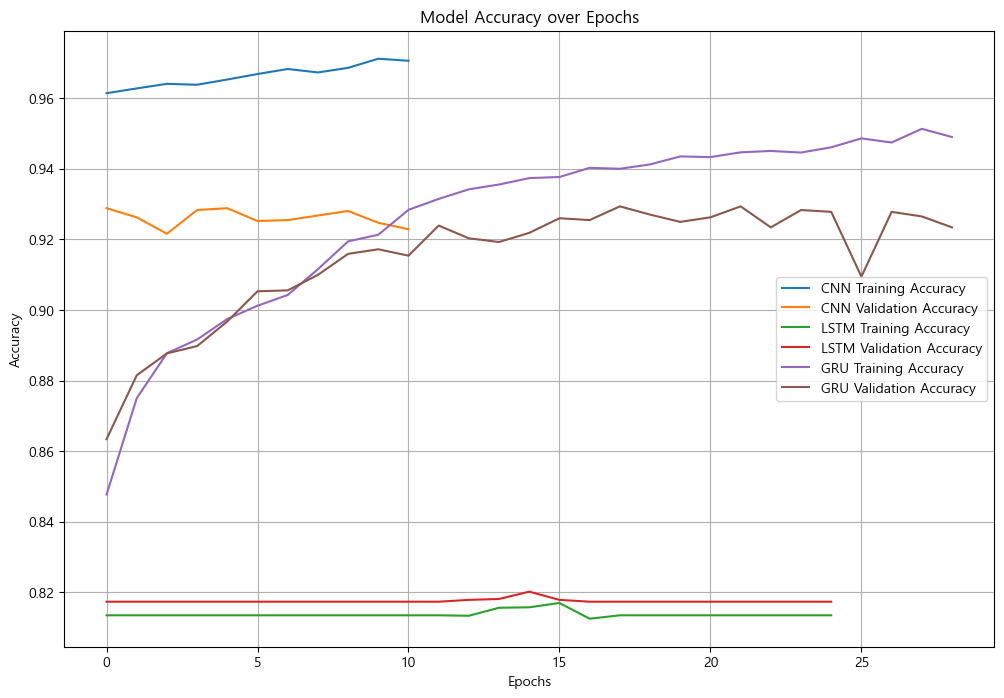

In [165]:
import matplotlib.pyplot as plt

# 그래프 그리기
plt.figure(figsize=(12, 8))

# CNN 성능 변화
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')

# LSTM 성능 변화
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')

# GRU 성능 변화
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy')

# 그래프 세부 설정
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()